<a href="https://colab.research.google.com/github/lukeawayne/colabconnect/blob/main/Dicom_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager
from pyod.models.knn import KNN
from pyod.utils.data import generate_data, get_outliers_inliers
import anomalib
from matplotlib import image
from matplotlib import pyplot
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour
import PIL
import cv2
from scipy import misc
import tensorflow as tf
import os
import imghdr
from tkinter import *
from tkinter.ttk import *
from tkinter import filedialog
from tkinter.filedialog import askopenfile
from PIL import Image, ImageOps, ImageFilter
from PIL import ImageTk as itk
import pydicom as dicom
from pydicom import dcmread
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

#### Saving out of memory errors

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')   #
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Dodgy images

In [ ]:
rm -rf `find . -type d -name .ipynb_checkpoints`

In [ ]:
#creates file
data_dir = 'data'


#creates file exts
image_exts = ['dcm']

os.listdir(data_dir)

['.DS_Store', 'Pacemaker', 'Normal']

## Loading Images

In [ ]:
#establishes dataset
data = tf.keras.utils.image_dataset_from_directory('data')

Found 885 files belonging to 2 classes.


In [ ]:
#allowing to iterate through the images
data_iterator = data.as_numpy_iterator()

#running the iterator
batch = data_iterator.next()

### Running the iterator

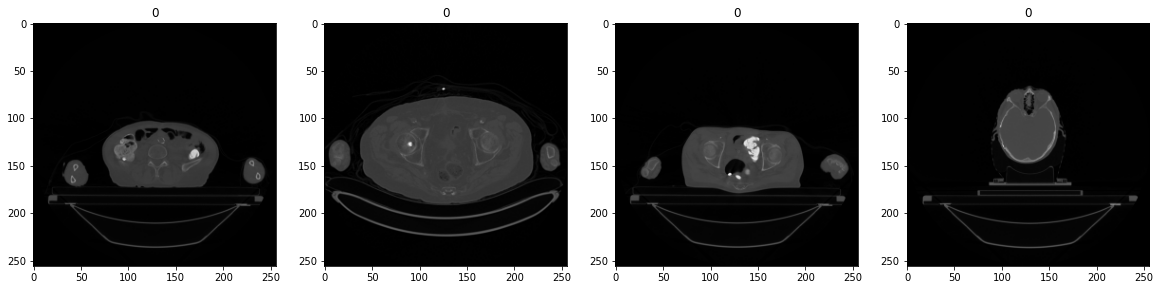

In [ ]:
#0 = no pacemaker
#1 = pacemaker
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## Scale the Data

In [ ]:
#data = data.map(lambda x,y: (x/255, y))

In [ ]:
data.as_numpy_iterator().next()

## Split Data

In [ ]:
train_size = 100#int(len(data)*.7)
val_size = 50#int(len(data)*.22)
test_size = 25#int(len(data)*.12)
train_size, val_size, test_size, len(data)

(100, 50, 25, 28)

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## Deep Learning Model

In [ ]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
model = Sequential()

In [ ]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 30, 30, 16)      

## Train

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=5, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/5
28/28 [==============================] - 66s 2s/step - loss: 6.3099 - accuracy: 0.8667
Epoch 2/5
13/28 [============>.................] - ETA: 34s - loss: 0.0780 - accuracy: 0.9904

KeyboardInterrupt: 

## Plot Performace

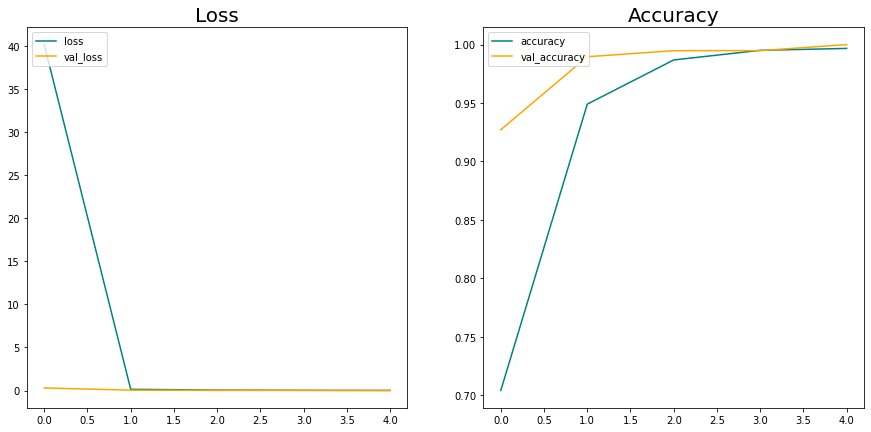

In [ ]:
#plotting
fig, ax = plt.subplots(ncols=2, figsize=(15,7))

#loss
ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val_loss')
ax[0].set_title("Loss", fontsize=20)
ax[0].legend(loc="upper left")

#accuracy
ax[1].plot(hist.history['accuracy'], color='teal', label='accuracy')
ax[1].plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
ax[1].set_title('Accuracy', fontsize=20)
ax[1].legend(loc="upper left")

## Evaluate

In [ ]:
#initilizing resutls
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

#running through the model with different images
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

#printing setup
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


## Test

In [ ]:
def dicom2image(x):
    ds = x.pixel_array
    pic_arr = ds.astype(np.uint8)
    image = Image.fromarray(pic_arr)
    image.save("test.png")
    return image

In [ ]:
image_path = '/Users/lukelayman/MProject/CT_4/ZZZ.LUKE^CT4_ANON54361_CT_2023-08-16_082359_Onco.Chest_iDose.(3)_n333__00000/2.16.840.1.114362.1.12013697.26296774060.651887536.762.591.dcm'
image_path2 = '/Users/lukelayman/MProject/CT_4/ZZZ.LUKE^CT4_ANON54361_CT_2023-08-16_082359_Onco.Chest_iDose.(3)_n333__00000/2.16.840.1.114362.1.12013697.26296774060.651887536.906.728.dcm'

#x = dcmread(image_path)
x2 = dcmread(image_path2)
#ximg = dicom2image(x)
ximg2 = dicom2image(x2)

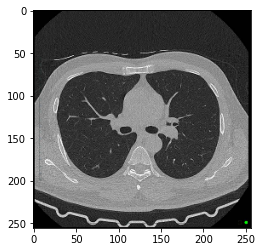

In [ ]:
#loading images
img = cv2.imread('p1test.png')
img2 = cv2.imread('pacemakertest.png')
img3 = cv2.imread('chestCT.jpeg')

#creating test value
resize = tf.image.resize(img3, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
#predicting model & looking at value
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

array([[0.48426354]], dtype=float32)

In [ ]:
#truth statement if pacemaker is present or not
if yhat > 0.5:
    print(f'Pacemaker Present')
else:
    print(f'No Pacemaker Present')

No Pacemaker Present
